# 08. More Sessions (3000)

Use the same datasets and models, but with 3000 total sessions and 100 events per session.

In [1]:
import pandas as pd
import numpy as np

import gc
from typing import Tuple
import logging

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras import optimizers
from keras import callbacks


from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns
import yellowbrick as yb

2023-02-26 17:08:45.574341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 17:08:45.711329: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-26 17:08:45.714989: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/current/lib/native:/opt/hadoop/current/lib/native
2023-02-26 17:08:45.7

In [2]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [3]:
# Set the GPU memory from growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[]


2023-02-26 17:08:48.218286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/current/lib/native:/opt/hadoop/current/lib/native
2023-02-26 17:08:48.218347: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-26 17:08:48.218382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lena): /proc/driver/nvidia/version does not exist


## Load the prepared and vectorized data

In [4]:
X_train = np.load('data/05/3000_100/X_train.npz')['arr_0']
X_val = np.load('data/05/3000_100/X_val.npz')['arr_0']
X_test = np.load('data/05/3000_100/X_test.npz')['arr_0']

y_train = np.load('data/05/3000_100/y_train.npz')['arr_0']
y_val = np.load('data/05/3000_100/y_val.npz')['arr_0']
y_test = np.load('data/05/3000_100/y_test.npz')['arr_0']

gc.collect()

11

In [5]:
print('X_train.shape:', X_train.shape)
print('X_val.shape:', X_val.shape)
print('X_test.shape:', X_test.shape)

print('y_train.shape:', y_train.shape)
print('y_val.shape:', y_val.shape)
print('y_test.shape:', y_test.shape)

X_train.shape: (37800, 100, 340)
X_val.shape: (8100, 100, 340)
X_test.shape: (8100, 100, 340)
y_train.shape: (37800,)
y_val.shape: (8100,)
y_test.shape: (8100,)


## Modeling Functions

In [6]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()        

In [7]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [8]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)
        #print(f'Threshold: {threshold:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

In [9]:
def train_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list) -> callbacks.History:
    """
    Train the keras model based on the parameters.

    Parameters
    ----------
    model : keras.models
        The model to train.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    
    Returns
    -------
    keras.callbacks.History
        The history of the training.
    """
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    # fit the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val))
    
    return history

In [10]:
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    
    plot_loss(history)
    plot_accuracy(history)

    y_test_score = model.predict(X_test)
    threshold, _, _ = optimize_f1(y_test, y_test_score)

    print(classification_report(y_test, y_test_score > threshold))
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold

In [11]:
def train_and_test_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list) -> float:
    """
    Train and test the model.

    Parameters
    ----------
    model : keras.models
        The model to train and test.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    gc.collect()

    return test_model(model, history, X_test, y_test)

In [12]:
def global_train_model(model,
                       epochs: int,
                       batch_size: int,
                       optimizer,
                       loss: str,
                       metrics: list) -> float:
        """
        Train the model using the global data.

        Parameters
        ----------
        model : keras.models
                The model to train.
        epochs : int
                The number of epochs.
        batch_size : int
                The batch size.
        optimizer : keras.optimizers
                The optimizer.
        loss : str
                The loss function.
        metrics : list
                The metrics.

        Returns
        -------
        float
                The optimized threshold for the best F1 score.
        """
        global X_train
        global y_train
        global X_val
        global y_val
        global X_test
        global y_test

        return train_and_test_model(
                model=model,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                X_test=X_test,
                y_test=y_test,
                epochs=epochs,
                batch_size=batch_size,
                optimizer=optimizer,
                loss=loss,
                metrics=metrics)

## Parameters

In [13]:
learning_rate = 0.001
first_layer_size = 32
epochs = 10
batch_size = 10

loss = 'binary_crossentropy'
metrics = ['accuracy']

## Simple Flattening

A very simple model that is not considering the sequence of events and flattens the input data.

In [14]:
# define the model
model = Sequential()
model.add(layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(first_layer_size, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2023-02-26 17:09:20.193777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
3780/3780 [==============================] - 26s 7ms/step - loss: 0.5531 - accuracy: 0.7335 - val_loss: 0.5353 - val_accuracy: 0.7347
Epoch 2/10
3780/3780 [==============================] - 30s 8ms/step - loss: 0.5235 - accuracy: 0.7415 - val_loss: 0.5279 - val_accuracy: 0.7362
Epoch 3/10
3780/3780 [==============================] - 28s 7ms/step - loss: 0.5219 - accuracy: 0.7415 - val_loss: 0.5322 - val_accuracy: 0.7388
Epoch 4/10
3780/3780 [==============================] - 25s 7ms/step - loss: 0.5211 - accuracy: 0.7449 - val_loss: 0.5382 - val_accuracy: 0.7319
Epoch 5/10
3780/3780 [==============================] - 24s 6ms/step - loss: 0.5212 - accuracy: 0.7432 - val_loss: 0.5596 - val_accuracy: 0.7373
Epoch 6/10
3780/3780 [==============================] - 24s 6ms/step - loss: 0.5239 - accuracy: 0.7436 - val_loss: 0.5367 - val_accuracy: 0.7369
Epoch 7/10
3780/3780 [==============================] - 24s 6ms/step - loss: 0.5235 - accuracy: 0.7429 - val_loss: 0.5348 - val_ac

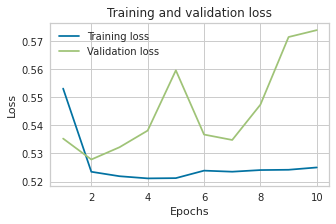

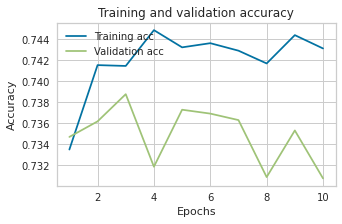

254/254 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      2340
           1       0.81      0.78      0.80      5760

    accuracy                           0.71      8100
   macro avg       0.65      0.66      0.66      8100
weighted avg       0.72      0.71      0.72      8100

Optimized threshold for best F1: 0.56


0.56

In [15]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)

## Simple RNN

In [16]:
model = Sequential()
model.add(layers.SimpleRNN(first_layer_size, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/10
3780/3780 [==============================] - 85s 22ms/step - loss: 0.5280 - accuracy: 0.7348 - val_loss: 0.5268 - val_accuracy: 0.7296
Epoch 2/10
3780/3780 [==============================] - 84s 22ms/step - loss: 0.5165 - accuracy: 0.7435 - val_loss: 0.5258 - val_accuracy: 0.7349
Epoch 3/10
3780/3780 [==============================] - 84s 22ms/step - loss: 0.5151 - accuracy: 0.7416 - val_loss: 0.5257 - val_accuracy: 0.7353
Epoch 4/10
3780/3780 [==============================] - 84s 22ms/step - loss: 0.5131 - accuracy: 0.7440 - val_loss: 0.5266 - val_accuracy: 0.7331
Epoch 5/10
3780/3780 [==============================] - 84s 22ms/step - loss: 0.5110 - accuracy: 0.7452 - val_loss: 0.5252 - val_accuracy: 0.7338
Epoch 6/10
3780/3780 [==============================] - 83s 22ms/step - loss: 0.5095 - accuracy: 0.7487 - val_loss: 0.5258 - val_accuracy: 0.7333
Epoch 7/10
3780/3780 [==============================] - 84s 22ms/step - loss: 0.5078 - accuracy: 0.7490 - val_loss: 0.5322 -

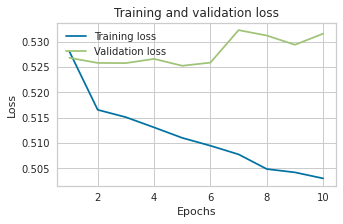

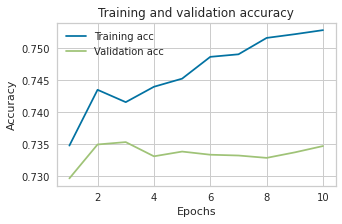

254/254 [==============================] - 3s 10ms/step
              precision    recall  f1-score   support

           0       0.48      0.54      0.51      2340
           1       0.81      0.76      0.78      5760

    accuracy                           0.70      8100
   macro avg       0.64      0.65      0.65      8100
weighted avg       0.71      0.70      0.71      8100

Optimized threshold for best F1: 0.66


0.66

In [17]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)

## Simple GRU

In [18]:
model = Sequential()
model.add(layers.GRU(first_layer_size, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/10
3780/3780 [==============================] - 139s 36ms/step - loss: 0.5240 - accuracy: 0.7367 - val_loss: 0.5231 - val_accuracy: 0.7360
Epoch 2/10
3780/3780 [==============================] - 135s 36ms/step - loss: 0.5155 - accuracy: 0.7430 - val_loss: 0.5238 - val_accuracy: 0.7368
Epoch 3/10
3780/3780 [==============================] - 136s 36ms/step - loss: 0.5131 - accuracy: 0.7444 - val_loss: 0.5210 - val_accuracy: 0.7427
Epoch 4/10
3780/3780 [==============================] - 136s 36ms/step - loss: 0.5110 - accuracy: 0.7461 - val_loss: 0.5202 - val_accuracy: 0.7398
Epoch 5/10
3780/3780 [==============================] - 137s 36ms/step - loss: 0.5091 - accuracy: 0.7475 - val_loss: 0.5207 - val_accuracy: 0.7426
Epoch 6/10
3780/3780 [==============================] - 136s 36ms/step - loss: 0.5079 - accuracy: 0.7481 - val_loss: 0.5207 - val_accuracy: 0.7389
Epoch 7/10
3780/3780 [==============================] - 137s 36ms/step - loss: 0.5055 - accuracy: 0.7503 - val_loss: 0

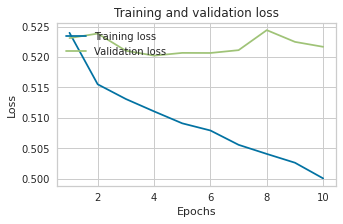

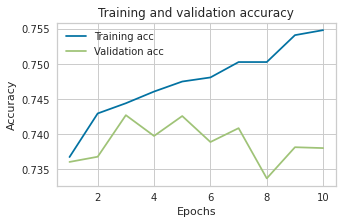

254/254 [==============================] - 5s 20ms/step
              precision    recall  f1-score   support

           0       0.55      0.47      0.51      2340
           1       0.80      0.84      0.82      5760

    accuracy                           0.74      8100
   macro avg       0.67      0.66      0.66      8100
weighted avg       0.73      0.74      0.73      8100

Optimized threshold for best F1: 0.58


0.58

In [19]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)

## Simple LSTM

In [20]:
model = Sequential()
model.add(layers.LSTM(first_layer_size, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/10
3780/3780 [==============================] - 140s 37ms/step - loss: 0.5238 - accuracy: 0.7369 - val_loss: 0.5231 - val_accuracy: 0.7360
Epoch 2/10
3780/3780 [==============================] - 137s 36ms/step - loss: 0.5160 - accuracy: 0.7430 - val_loss: 0.5228 - val_accuracy: 0.7348
Epoch 3/10
3780/3780 [==============================] - 138s 36ms/step - loss: 0.5144 - accuracy: 0.7424 - val_loss: 0.5210 - val_accuracy: 0.7411
Epoch 4/10
3780/3780 [==============================] - 137s 36ms/step - loss: 0.5131 - accuracy: 0.7451 - val_loss: 0.5216 - val_accuracy: 0.7404
Epoch 5/10
3780/3780 [==============================] - 137s 36ms/step - loss: 0.5117 - accuracy: 0.7467 - val_loss: 0.5200 - val_accuracy: 0.7383
Epoch 6/10
3780/3780 [==============================] - 137s 36ms/step - loss: 0.5107 - accuracy: 0.7466 - val_loss: 0.5270 - val_accuracy: 0.7373
Epoch 7/10
3780/3780 [==============================] - 136s 36ms/step - loss: 0.5096 - accuracy: 0.7477 - val_loss: 0

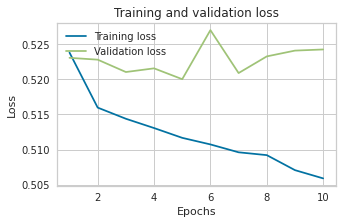

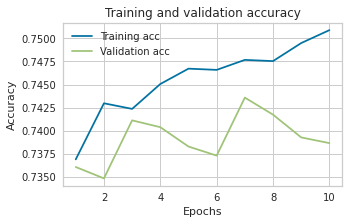

254/254 [==============================] - 5s 19ms/step
              precision    recall  f1-score   support

           0       0.50      0.55      0.52      2340
           1       0.81      0.77      0.79      5760

    accuracy                           0.71      8100
   macro avg       0.65      0.66      0.66      8100
weighted avg       0.72      0.71      0.71      8100

Optimized threshold for best F1: 0.66


0.66

In [21]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)

### Limit epocs to 8

Epoch 1/8
3780/3780 [==============================] - 138s 36ms/step - loss: 0.5053 - accuracy: 0.7514 - val_loss: 0.5256 - val_accuracy: 0.7394
Epoch 2/8
3780/3780 [==============================] - 136s 36ms/step - loss: 0.5044 - accuracy: 0.7521 - val_loss: 0.5270 - val_accuracy: 0.7354
Epoch 3/8
3780/3780 [==============================] - 137s 36ms/step - loss: 0.5027 - accuracy: 0.7527 - val_loss: 0.5275 - val_accuracy: 0.7391
Epoch 4/8
3780/3780 [==============================] - 136s 36ms/step - loss: 0.5022 - accuracy: 0.7546 - val_loss: 0.5254 - val_accuracy: 0.7399
Epoch 5/8
3780/3780 [==============================] - 137s 36ms/step - loss: 0.5001 - accuracy: 0.7554 - val_loss: 0.5314 - val_accuracy: 0.7384
Epoch 6/8
3780/3780 [==============================] - 136s 36ms/step - loss: 0.5003 - accuracy: 0.7554 - val_loss: 0.5267 - val_accuracy: 0.7349
Epoch 7/8
3780/3780 [==============================] - 138s 36ms/step - loss: 0.4985 - accuracy: 0.7584 - val_loss: 0.5278 -

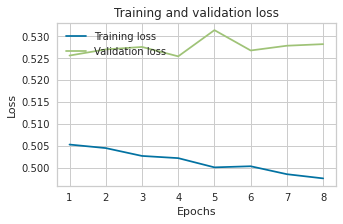

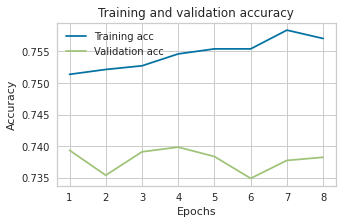

254/254 [==============================] - 5s 19ms/step
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      2340
           1       0.81      0.78      0.79      5760

    accuracy                           0.71      8100
   macro avg       0.65      0.66      0.66      8100
weighted avg       0.72      0.71      0.71      8100

Optimized threshold for best F1: 0.64


0.64

In [22]:
global_train_model(
    model=model,
    epochs=8,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)

### Increase batch size

Epoch 1/8
591/591 [==============================] - 40s 66ms/step - loss: 0.4916 - accuracy: 0.7614 - val_loss: 0.5305 - val_accuracy: 0.7363
Epoch 2/8
591/591 [==============================] - 38s 64ms/step - loss: 0.4865 - accuracy: 0.7649 - val_loss: 0.5354 - val_accuracy: 0.7337
Epoch 3/8
591/591 [==============================] - 38s 65ms/step - loss: 0.4834 - accuracy: 0.7677 - val_loss: 0.5342 - val_accuracy: 0.7351
Epoch 4/8
591/591 [==============================] - 38s 64ms/step - loss: 0.4806 - accuracy: 0.7692 - val_loss: 0.5380 - val_accuracy: 0.7337
Epoch 5/8
591/591 [==============================] - 38s 64ms/step - loss: 0.4779 - accuracy: 0.7726 - val_loss: 0.5385 - val_accuracy: 0.7288
Epoch 6/8
591/591 [==============================] - 38s 65ms/step - loss: 0.4753 - accuracy: 0.7728 - val_loss: 0.5407 - val_accuracy: 0.7314
Epoch 7/8
591/591 [==============================] - 39s 66ms/step - loss: 0.4734 - accuracy: 0.7745 - val_loss: 0.5429 - val_accuracy: 0.7272

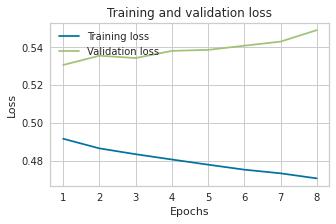

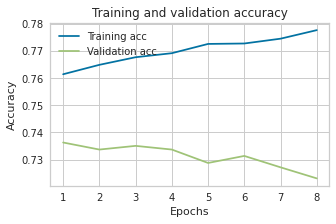

254/254 [==============================] - 5s 18ms/step
              precision    recall  f1-score   support

           0       0.49      0.53      0.51      2340
           1       0.80      0.78      0.79      5760

    accuracy                           0.71      8100
   macro avg       0.65      0.65      0.65      8100
weighted avg       0.71      0.71      0.71      8100

Optimized threshold for best F1: 0.61


0.61

In [23]:
global_train_model(
    model=model,
    epochs=8,
    batch_size=64,
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics)

### Decrease learning rate

Epoch 1/8
591/591 [==============================] - 41s 67ms/step - loss: 0.4629 - accuracy: 0.7833 - val_loss: 0.5487 - val_accuracy: 0.7252
Epoch 2/8
591/591 [==============================] - 38s 64ms/step - loss: 0.4596 - accuracy: 0.7846 - val_loss: 0.5499 - val_accuracy: 0.7236
Epoch 3/8
591/591 [==============================] - 38s 64ms/step - loss: 0.4579 - accuracy: 0.7861 - val_loss: 0.5506 - val_accuracy: 0.7249
Epoch 4/8
591/591 [==============================] - 38s 65ms/step - loss: 0.4566 - accuracy: 0.7869 - val_loss: 0.5517 - val_accuracy: 0.7247
Epoch 5/8
591/591 [==============================] - 38s 64ms/step - loss: 0.4554 - accuracy: 0.7875 - val_loss: 0.5528 - val_accuracy: 0.7237
Epoch 6/8
591/591 [==============================] - 38s 64ms/step - loss: 0.4545 - accuracy: 0.7883 - val_loss: 0.5538 - val_accuracy: 0.7241
Epoch 7/8
591/591 [==============================] - 38s 65ms/step - loss: 0.4536 - accuracy: 0.7893 - val_loss: 0.5549 - val_accuracy: 0.7237

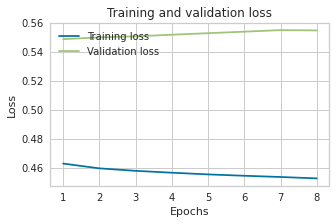

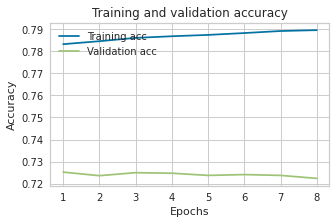

254/254 [==============================] - 5s 18ms/step
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2340
           1       0.80      0.79      0.79      5760

    accuracy                           0.71      8100
   macro avg       0.64      0.65      0.65      8100
weighted avg       0.71      0.71      0.71      8100

Optimized threshold for best F1: 0.62


0.62

In [24]:
global_train_model(
    model=model,
    epochs=8,
    batch_size=64,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)

### Add a dropout layer

In [25]:
model = Sequential()
model.add(layers.LSTM(first_layer_size, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/20
591/591 [==============================] - 41s 67ms/step - loss: 0.5910 - accuracy: 0.6878 - val_loss: 0.5399 - val_accuracy: 0.7140
Epoch 2/20
591/591 [==============================] - 38s 64ms/step - loss: 0.5339 - accuracy: 0.7278 - val_loss: 0.5250 - val_accuracy: 0.7380
Epoch 3/20
591/591 [==============================] - 38s 65ms/step - loss: 0.5248 - accuracy: 0.7364 - val_loss: 0.5278 - val_accuracy: 0.7388
Epoch 4/20
591/591 [==============================] - 37s 62ms/step - loss: 0.5218 - accuracy: 0.7388 - val_loss: 0.5244 - val_accuracy: 0.7409
Epoch 5/20
591/591 [==============================] - 38s 64ms/step - loss: 0.5210 - accuracy: 0.7407 - val_loss: 0.5224 - val_accuracy: 0.7391
Epoch 6/20
591/591 [==============================] - 38s 65ms/step - loss: 0.5188 - accuracy: 0.7427 - val_loss: 0.5222 - val_accuracy: 0.7398
Epoch 7/20
591/591 [==============================] - 39s 65ms/step - loss: 0.5189 - accuracy: 0.7404 - val_loss: 0.5237 - val_accuracy:

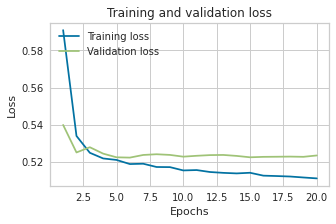

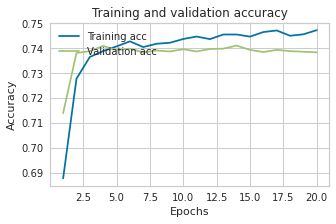

254/254 [==============================] - 5s 20ms/step
              precision    recall  f1-score   support

           0       0.51      0.55      0.53      2340
           1       0.81      0.79      0.80      5760

    accuracy                           0.72      8100
   macro avg       0.66      0.67      0.66      8100
weighted avg       0.72      0.72      0.72      8100

Optimized threshold for best F1: 0.65


0.65

In [26]:
global_train_model(
    model=model,
    epochs=20,
    batch_size=64,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)

### Compare with Recurrent Dropout

In [27]:
model = Sequential()

model.add(layers.LSTM(
    first_layer_size,
    dropout=0.1,
    input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/10
591/591 [==============================] - 43s 70ms/step - loss: 0.5661 - accuracy: 0.7129 - val_loss: 0.5291 - val_accuracy: 0.7359
Epoch 2/10
591/591 [==============================] - 41s 69ms/step - loss: 0.5194 - accuracy: 0.7423 - val_loss: 0.5223 - val_accuracy: 0.7393
Epoch 3/10
591/591 [==============================] - 41s 69ms/step - loss: 0.5152 - accuracy: 0.7428 - val_loss: 0.5217 - val_accuracy: 0.7405
Epoch 4/10
591/591 [==============================] - 41s 69ms/step - loss: 0.5136 - accuracy: 0.7434 - val_loss: 0.5217 - val_accuracy: 0.7400
Epoch 5/10
591/591 [==============================] - 41s 70ms/step - loss: 0.5127 - accuracy: 0.7438 - val_loss: 0.5237 - val_accuracy: 0.7386
Epoch 6/10
591/591 [==============================] - 41s 70ms/step - loss: 0.5117 - accuracy: 0.7454 - val_loss: 0.5218 - val_accuracy: 0.7405
Epoch 7/10
591/591 [==============================] - 40s 68ms/step - loss: 0.5112 - accuracy: 0.7451 - val_loss: 0.5226 - val_accuracy:

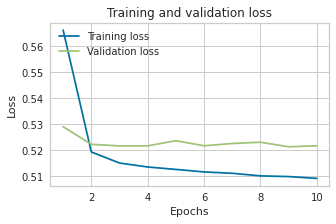

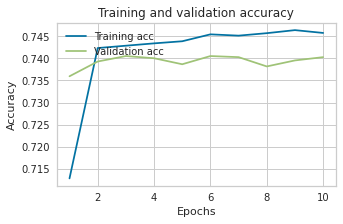

254/254 [==============================] - 5s 18ms/step
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      2340
           1       0.80      0.81      0.81      5760

    accuracy                           0.72      8100
   macro avg       0.66      0.66      0.66      8100
weighted avg       0.72      0.72      0.72      8100

Optimized threshold for best F1: 0.62


0.62

In [28]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=64,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)

In [29]:
model = Sequential()

model.add(layers.LSTM(
    first_layer_size,
    dropout=0.1,
    recurrent_dropout=0.5,
    input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/10
591/591 [==============================] - 106s 177ms/step - loss: 0.5724 - accuracy: 0.7124 - val_loss: 0.5326 - val_accuracy: 0.7305
Epoch 2/10
591/591 [==============================] - 103s 174ms/step - loss: 0.5244 - accuracy: 0.7365 - val_loss: 0.5240 - val_accuracy: 0.7343
Epoch 3/10
591/591 [==============================] - 103s 175ms/step - loss: 0.5183 - accuracy: 0.7405 - val_loss: 0.5216 - val_accuracy: 0.7377
Epoch 4/10
591/591 [==============================] - 103s 175ms/step - loss: 0.5162 - accuracy: 0.7413 - val_loss: 0.5219 - val_accuracy: 0.7364
Epoch 5/10
591/591 [==============================] - 103s 174ms/step - loss: 0.5150 - accuracy: 0.7417 - val_loss: 0.5221 - val_accuracy: 0.7372
Epoch 6/10
591/591 [==============================] - 103s 175ms/step - loss: 0.5136 - accuracy: 0.7427 - val_loss: 0.5218 - val_accuracy: 0.7393
Epoch 7/10
591/591 [==============================] - 103s 174ms/step - loss: 0.5128 - accuracy: 0.7426 - val_loss: 0.5250 -

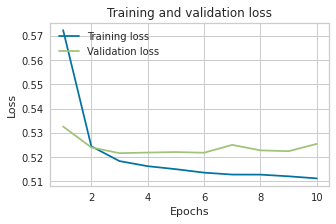

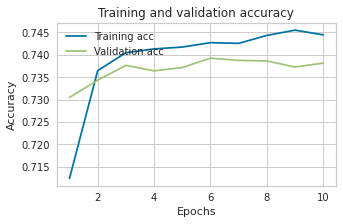

254/254 [==============================] - 9s 34ms/step
              precision    recall  f1-score   support

           0       0.50      0.57      0.53      2340
           1       0.81      0.77      0.79      5760

    accuracy                           0.71      8100
   macro avg       0.66      0.67      0.66      8100
weighted avg       0.72      0.71      0.72      8100

Optimized threshold for best F1: 0.68


0.68

In [30]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=64,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)

## Stacked Layers

Epoch 1/10
591/591 [==============================] - 220s 366ms/step - loss: 0.5672 - accuracy: 0.7131 - val_loss: 0.8386 - val_accuracy: 0.7248
Epoch 2/10
591/591 [==============================] - 215s 364ms/step - loss: 0.5275 - accuracy: 0.7336 - val_loss: 0.5241 - val_accuracy: 0.7370
Epoch 3/10
591/591 [==============================] - 215s 365ms/step - loss: 0.5203 - accuracy: 0.7367 - val_loss: 0.5258 - val_accuracy: 0.7364
Epoch 4/10
591/591 [==============================] - 216s 365ms/step - loss: 0.5190 - accuracy: 0.7391 - val_loss: 0.5251 - val_accuracy: 0.7364
Epoch 5/10
591/591 [==============================] - 216s 366ms/step - loss: 0.5172 - accuracy: 0.7413 - val_loss: 0.5590 - val_accuracy: 0.7384
Epoch 6/10
591/591 [==============================] - 215s 364ms/step - loss: 0.5194 - accuracy: 0.7412 - val_loss: 0.5842 - val_accuracy: 0.7363
Epoch 7/10
591/591 [==============================] - 215s 365ms/step - loss: 0.5265 - accuracy: 0.7426 - val_loss: 7.5895 -

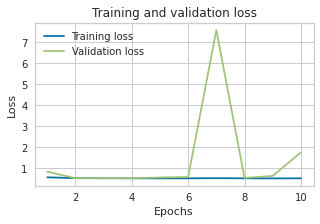

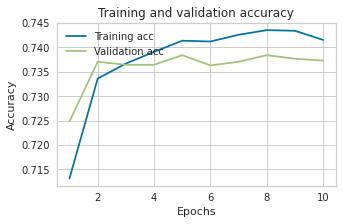

254/254 [==============================] - 17s 65ms/step
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2340
           1       0.80      0.81      0.81      5760

    accuracy                           0.72      8100
   macro avg       0.66      0.66      0.66      8100
weighted avg       0.72      0.72      0.72      8100

Optimized threshold for best F1: 0.61


0.61

In [31]:
# create the model
model = Sequential()
model.add(layers.LSTM(
    first_layer_size,
    dropout=0.1,
    recurrent_dropout=0.5,
    return_sequences=True,
    input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.LSTM(
    first_layer_size,
    activation='relu',
    dropout=0.1,
    recurrent_dropout=0.5))  
model.add(layers.Dense(1, activation='sigmoid'))

# train the model
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=64,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)